# **Import Library**

In [36]:
# --- Standard Libraries ---
import re
import csv
import string
import warnings
import datetime as dt
import requests
from io import StringIO

# --- Data Processing & Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Sklearn Tools ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# --- Imbalanced Data Handling ---
from imblearn.over_sampling import SMOTE

# --- Machine Learning Models ---
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# --- Deep Learning (Keras) ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# --- NLP Libraries ---
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# !pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import spacy
from textblob import TextBlob
from textblob.exceptions import NotTranslated

# --- Visualization Tools ---
from wordcloud import WordCloud
from collections import defaultdict

# --- Configuration ---
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
np.random.seed(0)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Memuat Dataset**

In [25]:
app_reviews_df = pd.read_csv('ulasan_aplikasi_Most_Relevant.csv')

In [26]:
# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = app_reviews_df.shape

print(f"Jumlah ulasan: {jumlah_ulasan}, Jumlah kolom: {jumlah_kolom}")

Jumlah ulasan: 121500, Jumlah kolom: 11


In [27]:
# Menampilkan lima baris pertama dari DataFrame app_reviews_df
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,595da86c-acc1-4a64-ae43-90ff85eaf53d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,terlalu terlalu terlalu... apk yg tidak bisa d...,1,1,4.31.1,2022-04-21 20:37:07,"Hai, mohon maaf atas kendala yang kamu alami. ...",2022-04-22 08:33:31,4.31.1
1,9f871c14-7d44-4f0d-8cbe-9904d42cf3b6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Gak usah pasang tarif tarif hemat, soalnya par...",1,145,5.14.2,2025-03-21 21:44:12,"Hai Kak Evi, mohon maaf atas ketidaknyamananny...",2025-03-21 22:05:01,5.14.2
2,825e4595-c073-4388-8229-415e372b6c01,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tinggal 2menit lg driver sampe di lokasi tiba-...,1,59,5.14.2,2025-03-26 07:35:56,"Hai Kak Wahyu, mohon maaf atas ketidaknyamanan...",2025-03-26 11:26:47,5.14.2
3,05536ac2-95a2-446a-878a-09a36c36e5a5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolong sistem pencarian otomatisnya kalo udah ...,3,0,5.14.2,2025-04-01 16:11:12,"Hai Kak Febry, mohon maaf atas ketidaknyamanan...",2025-04-01 16:37:20,5.14.2
4,cb8f275d-1318-4a5b-b40a-0c33cb89d08a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Update aplikasinya malah menyusahkan. Pesan da...,1,79,5.13.1,2025-03-17 05:25:29,"Hai Kak Michael, mohon maaf atas ketidaknyaman...",2025-03-17 07:18:53,5.13.1


# **Statistik Data**

In [28]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121500 entries, 0 to 121499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              121500 non-null  object
 1   userName              121500 non-null  object
 2   userImage             121500 non-null  object
 3   content               121499 non-null  object
 4   score                 121500 non-null  int64 
 5   thumbsUpCount         121500 non-null  int64 
 6   reviewCreatedVersion  96654 non-null   object
 7   at                    121500 non-null  object
 8   replyContent          39670 non-null   object
 9   repliedAt             39670 non-null   object
 10  appVersion            96654 non-null   object
dtypes: int64(2), object(9)
memory usage: 10.2+ MB


- **Tinjau Kilas:** Dataframe memiliki 11 kolom dengan total 121500 row.
- **Tipe Data:** Tipe data dari dataframe terdiri dari object dan int64. Untuk kolom at dan repliedAt, karena merupakan kolom waktu, akan diubah menjadi Dtype datetime.
- **Missing Values:** Berdasarkan info dataframe tersebut, kolom replyContent dan repliedAt memiliki banyak value yang merupakan NaN.

In [29]:
app_reviews_df['at'] = pd.to_datetime(app_reviews_df['at'])
app_reviews_df['repliedAt'] = pd.to_datetime(app_reviews_df['repliedAt'])

In [30]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = app_reviews_df.dropna()

In [31]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

print(f"Jumlah ulasan setelah menghapus duplikat: {jumlah_ulasan_setelah_hapus_duplikat}, Jumlah kolom: {jumlah_kolom_setelah_hapus_duplikat}")

Jumlah ulasan setelah menghapus duplikat: 30876, Jumlah kolom: 11


Dari hasil cleaning data ini, didapatkan hasil hanya tersisa 11 kolom dengan 7 kolom bertipe object atau string, 2 kolom bertipe integer, dan 2 kolom bertipe datetime. Untuk itu, akan dilakukan analisis univariat untuk tiap kolom beserta dengan analisis multivariat. Selanjutnya akan dilihat kembali isi kolom appVersion, replyContent, dan reply_time yang merupakan NaN.

# **Preprocessing Text**

1. `cleaningText(text)`: Fungsi ini digunakan untuk membersihkan teks dengan beberapa langkah, seperti menghapus mention, hashtag, RT (retweet), tautan (link), angka, dan tanda baca. Selain itu, itu juga menggantikan karakter newline dengan spasi dan menghilangkan spasi ekstra di awal dan akhir teks.

2. `casefoldingText(text)`: Fungsi ini mengonversi semua karakter dalam teks menjadi huruf kecil (lowercase), sehingga teks menjadi lebih seragam.

3. `tokenizingText(text)`: Fungsi ini digunakan untuk membagi teks menjadi daftar kata atau token. Ini berguna untuk mengurai teks menjadi komponen-komponen dasar.

4. `filteringText(text)`: Fungsi ini digunakan untuk menghapus kata-kata berhenti (stopwords) dalam teks. Anda telah memperbarui daftar kata-kata berhenti dengan beberapa kata tambahan.

5. `stemmingText(text)`: Fungsi ini menerapkan stemming pada teks, yaitu mengurangi kata-kata menjadi bentuk dasarnya. Anda menggunakan pustaka Sastrawi untuk melakukan stemming dalam bahasa Indonesia.

6. `toSentence(list_words)`: Fungsi ini digunakan untuk menggabungkan daftar kata-kata menjadi sebuah kalimat.

In [32]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi ganda dan strip teks
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

# def tokenizingText(text):
#     doc = nlp(text)
#     return [token.text for token in doc if token.is_alpha]  # Ambil hanya kata yang valid

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update([
        'iya', 'yaa', 'na', 'sih', 'ku', 'di', 'ya', 'loh', 'nya'
        'kah', 'woi', 'woii', 'woy', 'tp', 'dong', 'deh', 'sama', 'tuh', 'yg',
        'udah', 'kalo', 'tolong', 'rb', 'Jg', 'eh', 'jd', 'sy', 'saya'
    ])

    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [33]:
slangwords = {
    'ga': 'enggak',
    'dtg': 'dateng',
    'bnyk': 'lumayan banyak',
    'plg': 'balik',
    'km': 'kamu',
    'tp': 'namun',
    'bgs': 'oke',
    'temen': 'kawan',
    'trs': 'lanjut terus',
    'sore': 'petang',
    'lg': 'sedang',
    'wkt': 'jam',
    'mampir': 'berhenti sebentar',
    'cr': 'nyari',
    'kmrn': 'hari lalu',
    'drmn': 'asalnya dari mana',
    'asap': 'segera mungkin',
    'btw': 'omong-omong',
    'mantap': 'keren',
    'admin': 'pengelola',
    'apk': 'app',
    'top': 'paling oke',
    'cod': 'bayar di tempat',
    'klo': 'jika',
    'ojol': 'ojek daring',
    'klr': 'keluarin',
    'jemput': 'ambil',
    'kzl': 'gregetan',
    'blm': 'masih belum',
    'skrg': 'saat ini',
    'tlp': 'hubungi',
    'tau': 'mengerti',
    'dr': 'asal',
    'udh': 'udah',
    'batal': 'cancel',
    'diskon': 'harga miring',
    'sinyal': 'jaringan',
    'antri': 'nunggu giliran',
    'susah': 'ribet banget',
    'frekuensi': 'tingkat kejadian',
    'lapor': 'kasih tahu',
    'pengalaman': 'riwayat pemakaian',
    'jemputan': 'kendaraan penjemput',
    'tarif': 'biaya',
    'cpt': 'ngebut',
    'rating': 'nilai',
    'feedback': 'balikan',
    'kecewa': 'tidak puas',
    'partner': 'rekanan',
    'review': 'komentar pengguna',
    'komentar': 'tanggapan',
    'voucher': 'kode diskon',
    'refund': 'uang kembali',
    'konfirmasi': 'pastian',
    'respon': 'reaksi',
    'logistik': 'pengantaran',
    'transparan': 'terbuka',
    'respons': 'jawaban',
    'fleksibel': 'tidak kaku',
    'sesuai': 'match',
    'keuntungan': 'manfaat',
    'kerugian': 'kerugian',
    'promo': 'penawaran spesial',
    'layanan': 'service',
    'keperluan': 'hal penting',
    'puas': 'senang',
    'kualitas': 'mutu',
    'pengembalian': 'retur',
    'integritas': 'nilai jujur',
    'pelanggan': 'costumer',
    'reschedule': 'ubah jadwal',
    'ngebut': 'jalan kencang',
    'angkot': 'angkutan umum',
    'sopir': 'driver',
    'macet': 'jalan padat',
    'bayar': 'melunasi',
    'order': 'pesanan masuk',
    'tlpn': 'telepon',
    'dmn': 'posisi di mana',
    'ga': 'gak',
    'sih': 'emangnya',
    'bisa': 'dapat',
    'yah': 'ya',
    'aja': 'tok',
    'mlm': 'malem',
    'siang': 'tengah hari',
    'pagi': 'subuh',
    'cetak': 'print',
    'komplain': 'keluhan',
    'jemput': 'ambil penumpang',
    'antar': 'mengantarkan',
    'tujuan': 'alamat akhir',
    'positif': 'bagus',
    'negatif': 'kurang baik',
    'notifikasi': 'pemberitahuan',
    'akun': 'user',
    'penyelesaian': 'jalan keluar',
    'garansi': 'jaminan produk',
    'transaksi': 'aktivitas pembayaran',
    'estimasi': 'perkiraan waktu',
    'cepat': 'kilat',
    'praktis': 'gampang',
    'ribet': 'ruwet',
    'update': 'pembaruan sistem',
    'bensin': 'BBM',
    'bus': 'kendaraan umum besar',
    'service': 'servis',
    'drmn': 'asal dari mana',
    'sygn': 'sayang banget',
    'bkn': 'bukanlah',
    'klo': 'kalau',
    'gmn': 'gimana kabarnya',
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

def translate_to_indonesian(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='id')
        return str(translated)
    except NotTranslated:
        return text  # Tidak perlu diterjemahkan
    except Exception as e:
        print(f"Translation error: {e}")
        return text  # Jika error, kembalikan teks asli

In [34]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

# **Pelabelan**
Menggunakan Lexicon sesuai dengan materi di kelas

In [37]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [38]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score > 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    else:
        polarity = 'neutral'
        # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [39]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())



polarity
negative    20468
positive     8008
neutral      2400
Name: count, dtype: int64


# **Eksplorasi Label**

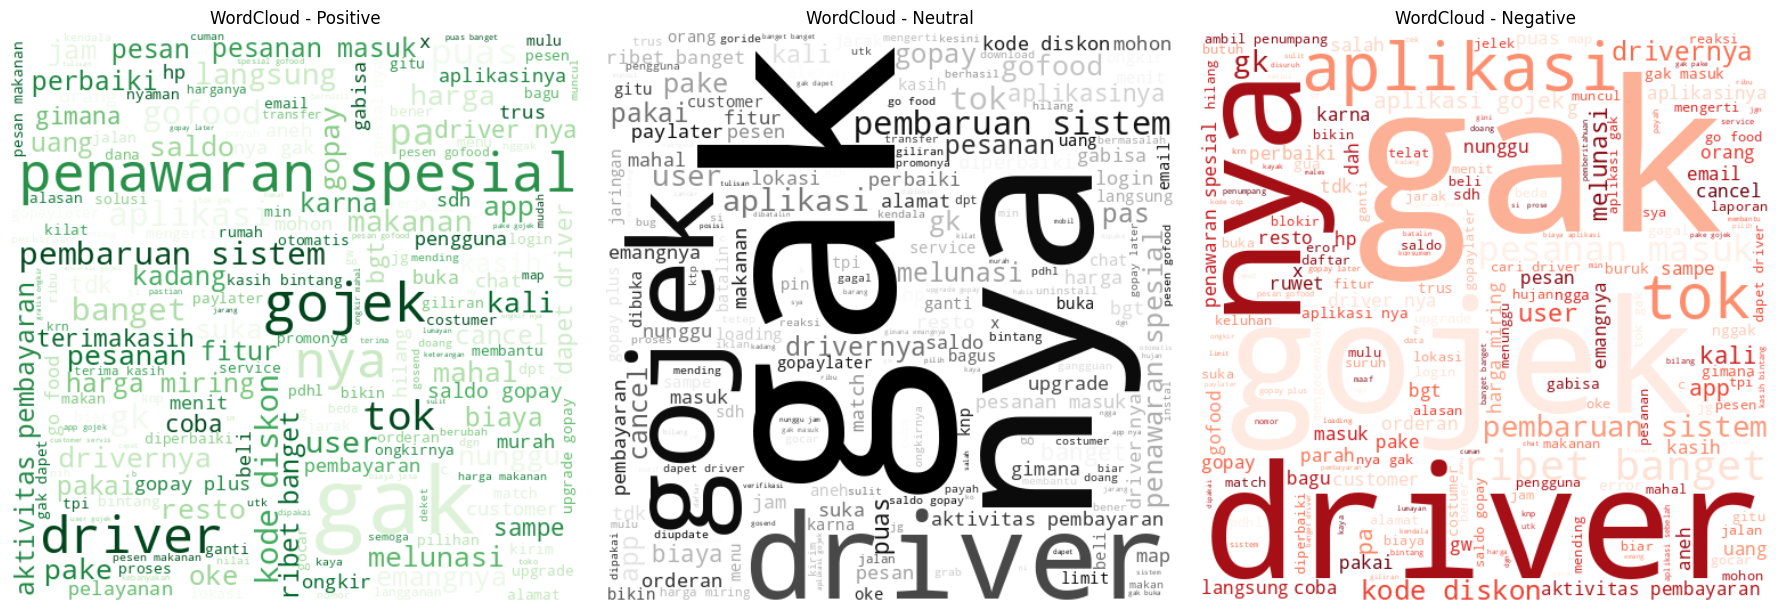

In [40]:
# Mengelompokkan ulasan berdasarkan label sentimen
text_data = defaultdict(str)
for label in ["positive", "neutral", "negative"]:
    text_data[label] = " ".join(clean_df[clean_df['polarity'] == label]['text_akhir'])

# Membuat WordCloud untuk setiap kategori sentimen
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sentiment_labels = ["positive", "neutral", "negative"]
colors = ["Greens", "gray", "Reds"]

for i, label in enumerate(sentiment_labels):
    wordcloud = WordCloud(width=500, height=500, background_color="white", colormap=colors[i]).generate(text_data[label])
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"WordCloud - {label.capitalize()}")

plt.tight_layout()
plt.show()


## **Skema Pelatihan**

In [41]:
# Load dataset
X_raw = clean_df['text_akhir']
y_raw = clean_df['polarity']

# Label encoding
y_encoded = LabelEncoder().fit_transform(y_raw)

# Fitur ekstraksi

def extract_features(method, X, ngram_range=(1, 1)):
    if method == "TF-IDF":
        cv = CountVectorizer(max_features=500, min_df=17, max_df=0.8)
        term_fit = cv.fit_transform(X)
        tfidf_transformer = TfidfTransformer().fit(term_fit)
        return tfidf_transformer.transform(term_fit).astype(np.float32), cv
    elif method == "BoW":
        cv = CountVectorizer(max_features=500, min_df=17, max_df=0.8, ngram_range=ngram_range)
        return cv.fit_transform(X).astype(np.float32), cv
    else:
        raise ValueError("Unknown feature extraction method")

# SMOTE

def apply_smote(X, y):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X, y)

# Model training (XGBoost, LightGBM)

def train_model(model_type, X_train, X_test, y_train, y_test):
    if model_type == "XGBoost":
        model = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, random_state=42)
    elif model_type == "LightGBM":
        model = LGBMClassifier(n_estimators=300, num_leaves=100, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
    else:
        raise ValueError("Unknown model type")
    model.fit(X_train, y_train)
    return accuracy_score(y_train, model.predict(X_train)), accuracy_score(y_test, model.predict(X_test))

# Deep learning model
def keras_dense_bow(X, y):
    y_cat = to_categorical(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(1080, activation='relu'), Dropout(0.2), BatchNormalization(),
        Dense(512, activation='relu'), Dropout(0.2), BatchNormalization(),
        Dense(256, activation='relu'), Dropout(0.3), BatchNormalization(),
        Dense(128, activation='relu'), Dropout(0.4), BatchNormalization(),
        Dense(64, activation='relu'), Dropout(0.3), BatchNormalization(),
        Dense(32, activation='relu'), Dropout(0.2),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
              callbacks=[EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)],
              verbose=2)

    # Evaluasi akurasi (jika ingin)
    acc_train = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
    acc_test = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

    return model, acc_train, acc_test


In [42]:
# Simpan akurasi dengan format tambahan untuk tabel
results = []

# Eksperimen model ML
experiments = [
    {"model": "XGBoost", "feature": "BoW", "split": 0.2},
    {"model": "LightGBM", "feature": "TF-IDF", "split": 0.2},
    {"model": "LightGBM", "feature": "BoW", "split": 0.25},
    {"model": "XGBoost", "feature": "TF-IDF", "split": 0.25},
]

for exp in experiments:
    split_pct = f"{int((1 - exp['split']) * 100)}/{int(exp['split'] * 100)}"
    print(f"\n🔍 Running experiment: Model={exp['model']}, Feature={exp['feature']}, Split={split_pct}")

    # Feature extraction
    X_transformed, _ = extract_features(exp['feature'], X_raw)

    # SMOTE balancing
    X_bal, y_bal = apply_smote(X_transformed, y_encoded)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=exp['split'], random_state=42)

    # Model training
    acc_train, acc_test = train_model(exp['model'], X_train, X_test, y_train, y_test)

    # Save result
    results.append({
        "Model": f"{exp['model']} ({exp['feature']})",
        "Train Accuracy": round(acc_train, 2),
        "Test Accuracy": round(acc_test, 2),
        "Train/Test Split": split_pct
    })

    print(f"✅ Train Accuracy: {acc_train:.2f}")
    print(f"✅ Test Accuracy:  {acc_test:.2f}")

# Eksperimen Deep Learning (Keras Dense dengan BoW)
print("\n🤖 Running experiment: Model=Keras Dense, Feature=BoW, Split=80/20")
X_bow, cv = extract_features("BoW", X_raw, ngram_range=(1, 2))
X_bal_dl, y_bal_dl = apply_smote(X_bow.toarray(), y_encoded)

model, acc_train_dl, acc_test_dl = keras_dense_bow(X_bal_dl, y_bal_dl)

results.append({
    "Model": "Keras Dense (BoW)",
    "Train Accuracy": round(acc_train_dl, 2),
    "Test Accuracy": round(acc_test_dl, 2),
    "Train/Test Split": "80/20"
})

print(f"✅ Train Accuracy (Keras): {acc_train_dl:.2f}")
print(f"✅ Test Accuracy  (Keras): {acc_test_dl:.2f}")



🔍 Running experiment: Model=XGBoost, Feature=BoW, Split=80/20
✅ Train Accuracy: 0.92
✅ Test Accuracy:  0.88

🔍 Running experiment: Model=LightGBM, Feature=TF-IDF, Split=80/20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82382
[LightGBM] [Info] Number of data points in the train set: 49123, number of used features: 500
[LightGBM] [Info] Start training from score -1.095462
[LightGBM] [Info] Start training from score -1.098022
[LightGBM] [Info] Start training from score -1.102365
✅ Train Accuracy: 0.99
✅ Test Accuracy:  0.92

🔍 Running experiment: Model=LightGBM, Feature=BoW, Split=75/25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you ca

In [43]:
# Menampilkan hasil sebagai tabel
results_df = pd.DataFrame(results)
print("\n=== Summary of All Results ===")
print(results_df.to_string(index=False))


=== Summary of All Results ===
            Model  Train Accuracy  Test Accuracy Train/Test Split
    XGBoost (BoW)            0.92           0.88            80/20
LightGBM (TF-IDF)            0.99           0.92            80/20
   LightGBM (BoW)            0.98           0.91            75/25
 XGBoost (TF-IDF)            0.93           0.86            75/25
Keras Dense (BoW)            0.95           0.91            80/20


***Notes:***  

*   Berhasil melakukan pemodelan sesuai dengan contoh 3 percobaan skema pelatihan dengan adanya 2 kombinasi yang berbeda
*   Menerapkan algoritma Deep Learning
*   Score di atas 0.92 untuk LightGBM (TF-IDF)



# **Hyperparameter Tuning**

In [44]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# # === Proses Eksekusi === #
# # Pilih metode fitur (TF-IDF atau Word2Vec)
# feature_method = "BoW"
# X_transformed, feature_model = extract_features(feature_method, X)

# # Terapkan SMOTE
# X_balanced, y_balanced = apply_smote(X_transformed, y_encoded)

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# # Hyperparameter Tuning untuk Random Forest
# best_rf = tune_hyperparameters("LGBM", X_train, y_train)

# **Inference**

In [45]:
# 1. Fit label encoder dari data training
label_encoder = LabelEncoder()
label_encoder.fit(clean_df['polarity'])

# 2. Transform teks baru
X_new_text = ["Aplikasi ini sangat bagus dan bermanfaat!"]
X_new_vector = cv.transform(X_new_text).toarray()

# 3. Prediksi
prediction = model.predict(X_new_vector)
predicted_label_index = np.argmax(prediction)
predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]

print("Predicted Sentiment:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Predicted Sentiment: negative
